In [1]:
!git clone https://github.com/tizianocolagrossi/ear_recognition_21-22.git
%cd /content/ear_recognition_21-22
!sudo apt-get install git-lfs
!git lfs pull
!pip install onnxruntime onnx

Cloning into 'ear_recognition_21-22'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 98 (delta 27), reused 83 (delta 16), pack-reused 0
Unpacking objects: 100% (98/98), done.
/content/ear_recognition_21-22
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (2,322 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to fr

MessageError: ignored

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (2,869 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 155335 files and directories c

In [13]:
!git lfs pull

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Not in a git repository.


In [2]:
import onnxruntime
import torchvision.transforms as transforms
import cv2
import numpy as np
import math
from PIL import Image

## class to import and execute onnx runtime for ead mask

class Mask_RCNN():
    
    def _to_numpy(self, tensor):
        return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

    def __init__(self, path_to_onnx):
        self.path=path_to_onnx
        self.ort_session = onnxruntime.InferenceSession(path_to_onnx)
    
    def __call__(self, image):
        to_tensor = transforms.ToTensor()
        tensor_img = to_tensor(image)
        ort_inputs = {self.ort_session.get_inputs()[0].name: self._to_numpy(tensor_img)}
        ort_outs = self.ort_session.run(None, ort_inputs)
        boxes = ort_outs[0]
        label = ort_outs[1]
        label_perc = ort_outs[2]
        segmentation = ort_outs[3]
        return (boxes, label, label_perc, segmentation)

class EarMasker():
  def __init__(self, model_path):
    self.model = Mask_RCNN(model_path)
  
  def __call__(self, path_input):
    model = self.model

    #path_input = f'./image/michele/m4.png'

    input_image_cv = cv2.imread(path_input)
    dimensions = input_image_cv.shape
    # check dimension for model input
    if dimensions != (702, 492, 3):
        return None

    input_image = Image.open(path_input)
    boxes, label, label_perc, segmentation = model(input_image)

    mask = self.get_final_mask(segmentation,label_perc, 0.60)

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS )
    color = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR) 

    cc_mask = cv2.drawContours(color.copy(), contours, -1, (255,255,255), -1)
    kernel = np.ones((3,3), np.uint8)
    img_erosion = cv2.erode(cc_mask, kernel, iterations=10)
    img_erosion = cv2.cvtColor(img_erosion, cv2.COLOR_BGR2GRAY)
    final_mask = cv2.bitwise_or(mask, img_erosion)
    color = cv2.cvtColor(final_mask, cv2.COLOR_GRAY2BGR) 

    threshold_minarea = 0.05
    threshold_maxarea = 0.8

    min_area = (input_image_cv.shape[0]*input_image_cv.shape[1])*threshold_minarea
    max_area = (input_image_cv.shape[0]*input_image_cv.shape[1])*threshold_maxarea

    rmagangle = None
    if len(contours) != 0:
        for cont in contours:
            # for fit ellipses at leat 5 points 
            # arerequired
            if len(cont) < 5:
                continue
            elps = cv2.fitEllipse(cont)
            (x, y), (MA, ma), angle = elps
            A = 3.1415 / 4 * MA * ma
            if math.isnan(A):
                continue
            if A<min_area or A>max_area:
                continue
            rmagangle = self.get_angle_majaxe(elps)

    final_mask = cv2.GaussianBlur(final_mask,(21,21),0)
    masked_ear = cv2.bitwise_and(input_image_cv, input_image_cv, mask=final_mask)

    if rmagangle != None:
        output = self.rotate(masked_ear, rmagangle-90)
    else:
        output = masked_ear

    return output


## helper function to transform segmentation matrix to image
  def segmentation_to_image(self,segmentation):
    msk = segmentation*255
    msk = msk.astype(np.uint8)
    return msk


## Start helper function for ear normalization

  def vconcat_resize_min(self,im_list, interpolation=cv2.INTER_CUBIC):
    w_min = min(im.shape[1] for im in im_list)
    im_list_resize = [cv2.resize(im, (w_min, int(im.shape[0] * w_min / im.shape[1])), interpolation=interpolation)
                      for im in filter(lambda x: (x.shape[0] != 0), im_list)]
    return cv2.vconcat(im_list_resize)

  def hconcat_resize_min(self,im_list, interpolation=cv2.INTER_CUBIC):
    
    h_min = min(im.shape[0] for im in im_list)
    im_list_resize = [cv2.resize(im, (int(im.shape[1] * h_min / im.shape[0]), h_min), interpolation=interpolation)
                      for im in filter(lambda x: (x.shape[1] != 0), im_list)]
    return cv2.hconcat(im_list_resize)

  def rotate(self,rotateImage, angle):
    # Taking image height and width
    (imgHeight, imgWidth) = rotateImage.shape[:2]
    
    # Computing the centre x,y coordinates
    # of an image
    centreY, centreX = imgHeight//2, imgWidth//2
  
    # Computing 2D rotation Matrix to rotate an image
    rotationMatrix = cv2.getRotationMatrix2D((centreY, centreX), angle, 1.0)
  
    # Now will take out sin and cos values from rotationMatrix
    # Also used numpy absolute function to make positive value
    cosofRotationMatrix = np.abs(rotationMatrix[0][0])
    sinofRotationMatrix = np.abs(rotationMatrix[0][1])
  
    # Now will compute new height & width of
    # an image so that we can use it in
    # warpAffine function to prevent cropping of image sides
    diagonal = int(math.sqrt(imgWidth**2+imgHeight**2))
    newImageHeight = diagonal
    newImageWidth = diagonal
  
    # After computing the new height & width of an image
    # we also need to update the values of rotation matrix
    rotationMatrix[0][2] += (newImageWidth/2) - centreX
    rotationMatrix[1][2] += (newImageHeight/2) - centreY
  
    # Now, we will perform actual image rotation
    rotatingimage = cv2.warpAffine(
        rotateImage, rotationMatrix, (newImageWidth, newImageHeight))
    
    # get the nonzero alpha coordinates
    y,x,_ = rotatingimage.nonzero() 
    minx = np.min(x)
    miny = np.min(y)
    maxx = np.max(x)
    maxy = np.max(y) 
    cropImg = rotatingimage.copy()
    cropImg = cropImg[miny:maxy, minx:maxx]

    return cropImg

  def draw_ellps_metadata(self,elps,color):
    (x, y), (MA, ma), angle = elps
    #draw ellypses
    color = cv2.ellipse(color, elps, (0,0,255), 2)
    #draw ellipses center
    color = cv2.circle(color, (int(x),int(y)), 4, (0, 0, 0), -1)
    # draw vertical line
    # compute major radius
    rmajor = max(MA,ma)/2
    if angle > 90:
        rmagangle = angle - 90
    else:
        rmagangle = angle + 90
    xtop = x + math.cos(math.radians(rmagangle))*rmajor
    ytop = y + math.sin(math.radians(rmagangle))*rmajor
    xbot = x + math.cos(math.radians(rmagangle+180))*rmajor
    ybot = y + math.sin(math.radians(rmagangle+180))*rmajor
    color = cv2.line(color, (int(xtop),int(ytop)), (int(xbot),int(ybot)), (255, 255, 0), 2)
    return rmagangle, color

  def get_angle_majaxe(self,elps):
    (x, y), (MA, ma), angle = elps
    # compute major radius
    rmajor = max(MA,ma)/2
    if angle > 90:
        rmagangle = angle - 90
    else:
        rmagangle = angle + 90
    return rmagangle

  def get_final_mask(self,segmentation, label_perc, threshold):
    _,c,r = segmentation[0].shape
    final_mask = np.zeros((c, r, 1), dtype = "uint8")
    for inx in range(len(label_perc)):
        if label_perc[inx]<threshold:
            continue
        # show original image
        msk = self.segmentation_to_image(segmentation[inx][0])
        final_mask = cv2.bitwise_or(final_mask, msk)
    return final_mask

    
    

In [3]:
import numpy as np
import tensorflow as tf
import keras
                         

class Feature_Extractor():
    def load(self,model_path):
        model = keras.models.load_model(model_path)
        return model

    def __init__(self, model_path):
        model = self.load(model_path)
        flat_layer = model.get_layer("flatten")
        self.feature_extractor = keras.Model(inputs=model.input, outputs=flat_layer.output)
    
    def __call__(self, image):
        tensor = tf.convert_to_tensor(image, dtype=tf.float32)
        tensor = tf.image.resize(tensor, [176, 123])
        input_tensor = tf.expand_dims(tensor, axis=0)
        feature_vector = self.feature_extractor(input_tensor)
        feature_vector = feature_vector.numpy()[0]
        return feature_vector

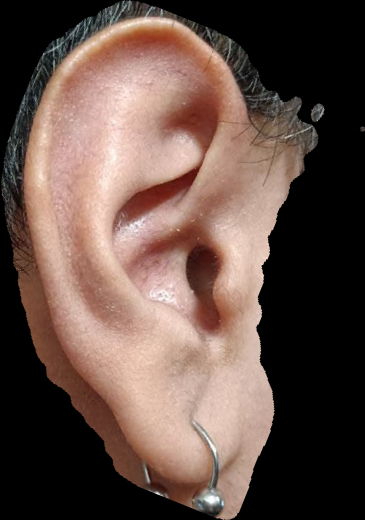

In [4]:
from google.colab.patches import cv2_imshow

masker = EarMasker('/content/ear_recognition_21-22/model_detection/ear_segmentation.onnx')
img = masker("/content/ear_recognition_21-22/image/davide/gallery/d2.png")
cv2_imshow(img)

[1.3872037, 1.8236276, 0.8309237, 2.2874055, 4.4628253, 1.0317847, -0.7787578, -1.5536757, -2.5940654, -1.4133751, -1.1803219, -6.169094, 0.94874245, -1.6621238, -2.2554345, -1.9422815, 3.8858433, 3.6036541, 1.3237327, -0.7480176, -0.88444537, 2.6831043, -0.63252527, -1.5588479, -1.1431011, -0.022000117, -2.0402303, 0.032018937, -0.9772424, -0.9636731, 2.3298585, -2.58246, -2.237978, 3.0239, -0.71174043, 3.3473992, -0.025608258, -2.363756, -1.8397268, 1.0789971, 1.7190222, -0.7047686, -0.36955005, -1.971206, 0.15580681, -1.5237081, 1.1000179, 0.28145513, 1.3468146, -0.59019923, 2.6743283, -0.94667375, -2.4175642, 0.9822187, -0.056126844, -0.046259515, -0.70956355, 0.8546703, 3.6624262, 0.6203335, -0.43261307, 3.7392654, 0.45003358, 0.67465335, 2.0640802, -0.22681393, 5.7278495, 0.5890358, 0.16462982, -2.6691535, 1.57796, 0.17351331, -1.4137177, 4.40371, 1.8389513, 3.0608401, 1.5030161, -2.658215, -2.698458, 1.4260508, 0.415509, 1.8232604, 2.444678, -1.3350321, -4.2646046, 0.36732697, -

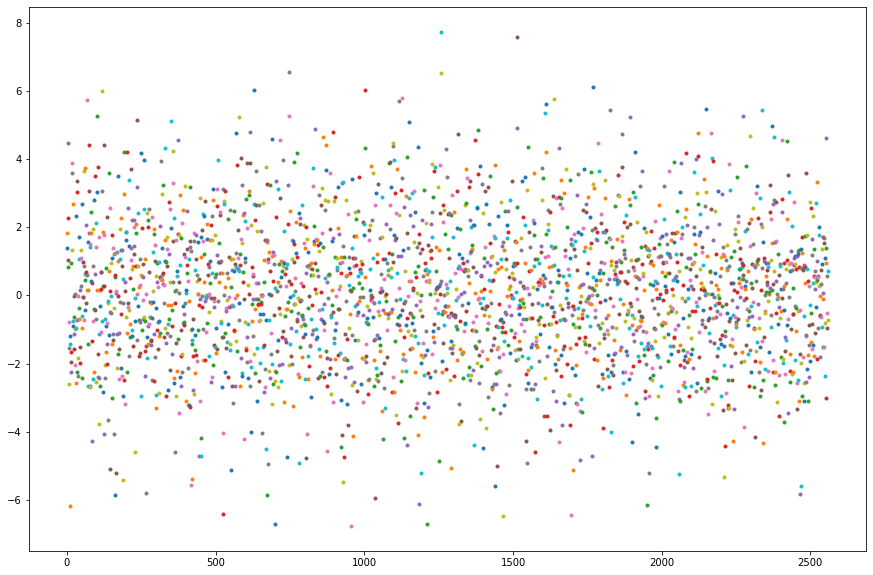

In [5]:
import matplotlib.pyplot as plt

fe = Feature_Extractor('/content/ear_recognition_21-22/model_features/CUSTOM_NET-500ep_b64_MaxP_DBCrop.h5')
arr = fe(img)
print(list(arr))
print(arr.shape)

plt.figure(figsize=[15, 10])
for i, val in enumerate(arr.tolist()):
  plt.plot(i, val, ".")
plt.show()

In [6]:
def image_to_feature(path_image):
  return fe(masker(path_image))

## Gallery creation

In [49]:


gallery = {}
gallery['davide']=[]
gallery['tiziano']=[]
gallery['michele']=[]

image_davide  = ['/content/ear_recognition_21-22/image/davide/gallery/d2.png','/content/ear_recognition_21-22/image/davide/gallery/d5.png'] 
image_michele = ['/content/ear_recognition_21-22/image/michele/gallery/m2.png', '/content/ear_recognition_21-22/image/michele/gallery/m4.png']
image_tiziano = ['/content/ear_recognition_21-22/image/tiziano/gallery/t1.png', '/content/ear_recognition_21-22/image/tiziano/gallery/t3.png']

for img_path_davide in image_davide:
  gallery['davide'].append(image_to_feature(img_path_davide))

for img_path_tiziano in image_tiziano:
  gallery['tiziano'].append(image_to_feature(img_path_tiziano))

for img_path_michele in image_michele:
  gallery['michele'].append(image_to_feature(img_path_michele))



In [75]:
import pickle

with open('./gallery_saved', 'wb') as file:
  pickle.dump(gallery, file)

In [8]:
import pickle

with open('/content/ear_recognition_21-22/gallery/gallery_saved', 'rb') as file:
  gallery = pickle.load(file)

## Ear identification test

In [9]:
from numpy import corrcoef

def coefficient_of_correlation(fv1, fv2):
  return corrcoef(fv1,fv2)

path_imput_image = '/content/ear_recognition_21-22/image/tiziano/probe/t8.png'
probe = image_to_feature(path_imput_image)

result = []

for key in gallery:
  for arr in gallery[key]:
    res = coefficient_of_correlation(probe, arr)
    result.append((res[0][1], key))

res = sorted(result, key=lambda tup: tup[0])
print(res)
print(res[-1])

[(0.5570455691861295, 'michele'), (0.5930406297887733, 'davide'), (0.706592515051271, 'michele'), (0.7553845384405565, 'tiziano'), (0.7761346829531821, 'davide'), (0.932169131146486, 'tiziano')]
(0.932169131146486, 'tiziano')
